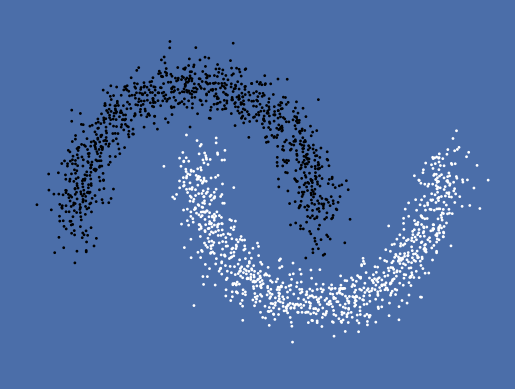

In [1]:
# all of these libraries are used for plotting
import numpy as np
import matplotlib.pyplot as plt

# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

In [2]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

In [3]:
class MyReLU(object):
    def forward(self, x):
        self.x = x
        return x * (x > 0)
        
    def backward(self, grad_output):
        return grad_output * (self.x > 0)
        
    def step(self, learning_rate):
        pass  # no parameters to update

class MySigmoid(object):
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, grad_output):
        return grad_output * self.output * (1 - self.output)

    def step(self, learning_rate):
        pass  # no parameters to update

In [4]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        self.n_output = n_output
        self.n_input = n_input
        self.mu_w = np.random.randn(n_output, n_input).reshape(-1)
        self.mu_b = np.random.randn(n_output)
        self.sigma_w = (np.random.randn(n_output, n_input).reshape(-1))**2
        self.sigma_b = np.random.randn(n_output)**2

    def forward(self, x):
        self.x = x
        self.weights = np.random.normal(self.mu_w, np.sqrt(self.sigma_w)).reshape(self.n_output, self.n_input)
        self.bias = np.random.normal(self.mu_b, np.sqrt(self.sigma_b))
        
        return np.dot(x, self.weights.T) + self.bias

    def backward(self, grad_output):
        # y_i = \sum_j W_{i,j} x_j + b_i
        # d y_i / d W_{i, j} = x_j
        # d loss / d y_i = grad_output[i]
        # so d loss / d W_{i,j} = x_j * grad_output[i]  (by the chain rule)
        dl_dw = np.outer(grad_output, self.x).reshape(-1)
        #dl_dw = next(iter(dl_dw))

        
        # d y_i / d b_i = 1
        # d loss / d y_i = grad_output[i]
        dl_dy = grad_output
        
        
        # now we need to compute the gradient with respect to x to continue the back propagation
        # d y_i / d x_j = W_{i, j}
        # to compute the gradient of the loss, we have to sum over all possible y_i in the chain rule
        # d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j)
        # YOUR CODE HERE
        #dl_dx = dl_dy @ self.weights
        #print(dl_dy)
        #print('&')
        #print(self.weights)
        dl_dx = [sum([dl_dy[i]*self.weights[i,j] for i in range(len(self.weights))]) for j in range(len(self.weights[0]))]
    
        self.grad_weights = dl_dw
        self.grad_bias = np.sum(grad_output, axis=0)
        return dl_dx
    
    def step(self, learning_rate = 0.01):
        

        self.sigma_w = ((1 - learning_rate) * self.sigma_w + self.grad_weights**2 * learning_rate)
        self.sigma_b = (1 - learning_rate) * self.sigma_b + self.grad_bias**2 * learning_rate

        self.mu_w -= (self.grad_weights / self.sigma_w) * learning_rate
        self.mu_b -= (self.grad_bias / self.sigma_b) * learning_rate

In [5]:
class MLP(object):
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def compute_loss3(self, out, label):    
        if out==0:
            out=1e-10
        loss=-np.mean((label * np.log(out) + (1-label) * np.log(1-out)))
        self.grad_output=-((label/out)+(label-1)/(1-out))
        return loss
    
    def compute_loss(self, out, label):
        BCE = -label*np.log(out[0])+(1-label)*np.log(1-out[0])
        self.grad_output = -(label/(out[0]+10**(-10)) - (1 - label) / (1 - out[0]+10**(-10)))
        return BCE
    
    def compute_loss2(self, out, label):
        # case where label is 0
        if label == 0:
            grad_output = -1 / (1 - out + 1e-10)
            loss0 = -np.mean(np.log(1 - out + 1e-10))
            self.grad_output = grad_output
            return loss0
        
        # case where label is 1
        grad_output = 1 / (out + 1e-10)
        loss1 = -np.mean(np.log(out + 1e-10))
        self.grad_output = grad_output
        return loss1

    def backward(self):
        grad_output = self.grad_output
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        # return grad_output

    def step(self, learning_rate):
        for layer in self.layers:
            layer.step(learning_rate)

    def train(self, X, y, n_iter, learning_rate):
        for _ in range(n_iter):
            loss = 0
            for x, label in zip(X, y):
                out = self.forward(x)
                loss += self.compute_loss(out, label)
                self.backward()
            loss /= len(X)
            self.step(learning_rate)
            print(loss)

In [14]:
h=50

# define your network with your Sequential
# it should be a linear layer with 2 inputs and h outputs, followed by a ReLU
# then a linear layer with h inputs and 1 outputs, followed by a sigmoid
# feel free to try other architectures

net = MLP([MyLinear(2, h), MyReLU(), MyLinear(h, 1), MySigmoid()])

[-0.23091009 -0.25233762  0.46890201  0.43142615 -0.43631019 -0.48260647
  0.52572702 -1.43651636 -0.02297898  0.0246603   0.31096039  1.35010695
 -0.01960819 -0.61712314  0.32091527  1.86243328  0.66208203  0.63090781
  1.12486084  0.71834725 -0.46521793 -0.81884129 -0.0993312   0.93034024
  0.25965098 -0.08328848 -1.82929722 -0.3639096   0.58014296  2.07956165
  0.86641571  0.15663459 -0.62313577  0.10409128 -0.97130499  2.50600882
  0.43939285  0.08094177 -0.23918294  0.1673728  -0.58100492  0.43209781
  0.42576872 -1.73308804 -2.31886293 -0.69182857  0.72349056 -0.43990596
 -0.16684492 -0.3981614   2.00145026 -0.08322953  0.27705252  1.00323091
  0.27902544  2.23077321 -1.06600816  2.55902492  0.39857888 -0.77439177
 -0.89608461  1.01038628 -1.55657767  1.68893591  3.68760669  2.10117444
  0.49074955  0.96620438  0.81654964  0.57207612  1.00993775  0.64245616
  1.02169713  0.63112451  0.71457623  1.71126432 -1.08438613 -1.01976925
  1.46259692  0.42032015  0.9172975  -0.33728962 -1

/var/folders/kk/m7r241y560174wvw5cvj2dfm0000gn/T/ipykernel_57556/118718062.py:18: RuntimeWarning: divide by zero encountered in log
  BCE = -label*np.log(out[0])+(1-label)*np.log(1-out[0])
/var/folders/kk/m7r241y560174wvw5cvj2dfm0000gn/T/ipykernel_57556/118718062.py:18: RuntimeWarning: invalid value encountered in scalar multiply
  BCE = -label*np.log(out[0])+(1-label)*np.log(1-out[0])


[ -0.2435227    1.50135785   0.02956395   0.10338053   1.45410173
  -8.35812949 -11.9406302   -1.64709556   1.09687322  -1.82495636
  -0.30532581   2.60703906  -0.1772931   -0.98542806   0.45451153
   0.85318152   0.81519287  -0.9388146    0.91582201   2.98233069
  -1.63812464   0.14085813  -0.05482604  -0.26873035  -0.09763286
  -3.90514546  -2.21744869  -0.1914932    1.04712523   1.23583007
   0.79470462  -1.18974511  -1.11109207  -1.25043286  -1.30056861
   2.82394314  -0.31057543   0.45165987 -17.45843306  -2.49099317
  -0.66672424  -1.45199685   0.1881785   -6.5477629   -2.93564181
  -0.14752738   1.21839874  -1.86281012  -0.38763693  -3.6646886
   0.9274078   -0.17905491  -2.86161338  -1.55318241   1.44601952
   4.56069257  -1.68760561   1.6835557    0.77842296  -2.1071269
  -1.69182692  -3.49849622  -2.14461693   2.9643627    3.50008895
  -1.18279364   0.75355624   2.56292071   1.01393617  -0.86879695
   0.64930914   2.57222865   0.63476445  -1.0225261    0.5574038
   0.79446801

/var/folders/kk/m7r241y560174wvw5cvj2dfm0000gn/T/ipykernel_57556/3826225859.py:14: RuntimeWarning: overflow encountered in exp
  self.output = 1 / (1 + np.exp(-x))


[-9.60237472e+00  5.21474148e+00 -3.33885102e+00 -7.20202782e+00
  1.38842461e+00 -1.69815181e+00 -3.44115645e+01  7.11223984e+00
  1.57980304e+00  2.65832225e+00  1.93450536e+00  1.03808459e+01
  6.91033640e-01 -1.24546894e-01 -1.84064414e+01 -5.99697165e+00
  1.65635597e+00  1.75170370e+01  2.65233313e+00  5.51798596e+00
  3.80367118e+00 -8.62181131e-01  4.53237605e+00  4.25780208e+00
  3.96447583e+00 -9.25216488e+00 -3.50514701e-01  7.20591204e+01
  2.81541088e+00  3.99034479e+00 -3.14618790e+00 -2.53426314e+01
  7.87430088e-01 -4.32831422e+00  2.51473935e+00  6.98312491e+00
 -2.07846935e+00  1.47713908e+01 -3.15511833e+01  3.74197350e+00
  5.65069301e+00  1.52259944e+01  3.03933945e+00 -4.07030452e+00
 -6.46017885e+00  2.32828580e+00  1.61492837e+00 -1.85740978e+01
 -1.07728826e+00 -1.40082808e-01  1.40836891e+02 -1.34783394e+02
 -1.98404018e+01  2.44082870e+01  1.55961204e+00  9.18359758e+00
  1.78989180e+00  3.74960171e+00 -1.41190055e+00 -1.93998433e+01
 -8.42045098e+00  1.50923

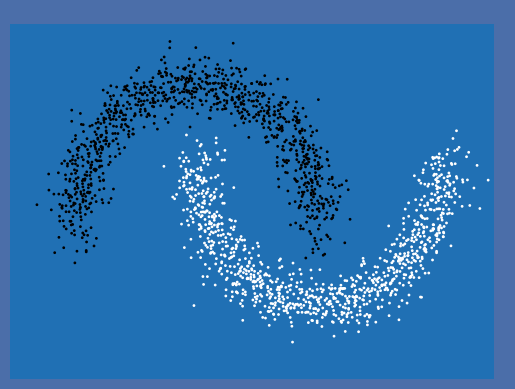

In [15]:
# unfortunately animation is not working on colab
# you should comment the following line if on colab
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
losses = []
learning_rate = 1e-2
for it in range(10000):
    
    # pick a random example id
    j = np.random.randint(1, len(X))


    # select the corresponding example and label
    example = X[j:j+1][0]
    
    label = Y[j]
    

    # do a forward pass on the example
    out = net.forward(example)

    # compute the loss according to your output and the label
    # YOUR CODE HERE
    loss = net.compute_loss(out, label)
    
    losses.append(loss)
    
    
    # backward pass
    # YOUR CODE HERE
    net.backward()
    
    # gradient step
    # YOUR CODE HERE
    net.step(learning_rate)

    # draw the current decision boundary every 250 examples seen
    if it % 250 == 0 : 
        plot_decision_boundary(ax, X,Y, net)
        fig.canvas.draw()
        for layer in net.layers:
            if hasattr(layer, 'mu_w'):
                print(layer.mu_w)
                print(layer.mu_b)
                print(layer.sigma_w)
                print(layer.sigma_b)
plot_decision_boundary(ax, X,Y, net)
fig.canvas.draw()